In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
sub = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/subs_data.csv')
print(sub.columns)
sub.describe(include='all')

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id'],
      dtype='object')


,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id
count,111668.000000,111668,111668,111668.000000,111668,111668.000000,111668.000000,111668.000000,111668,111668
unique,NaN,295,283,NaN,3,NaN,NaN,NaN,5,100000
top,NaN,2024-02-01,2024-11-01,NaN,monthly,NaN,NaN,NaN,PULSE,BJF6676601
freq,NaN,58435,43791,NaN,79239,NaN,NaN,NaN,49990,5
mean,117.737346,NaN,NaN,1.048779,NaN,29.027506,108.629281,0.040280,NaN,NaN
std,97.127672,NaN,NaN,0.269482,NaN,31.941318,31.557151,0.196616,NaN,NaN
min,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,1.000000,NaN,8.990000,86.880000,0.000000,NaN,NaN
50%,90.000000,NaN,NaN,1.000000,NaN,11.990000,107.880000,0.000000,NaN,NaN
75%,214.000000,NaN,NaN,1.000000,NaN,62.990000,131.880000,0.000000,NaN,NaN


In [ ]:
demo = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/demo_data.csv')
print(demo.columns)
demo.describe(include='all')

Index(['Capstone_id', 'Age', 'Gender', 'Location', 'Email', 'Income'], dtype='object')


,Capstone_id,Age,Gender,Location,Email,Income
count,100000,100000.000000,100000,100000,100000,100000.000000
unique,100000,NaN,3,38190,85853,NaN
top,COV9783244,NaN,Male,New Michael,nsmith@example.com,NaN
freq,1,NaN,49912,105,13,NaN
mean,NaN,54.430340,NaN,NaN,NaN,55486.459730
std,NaN,13.420644,NaN,NaN,NaN,22917.913088
min,NaN,18.000000,NaN,NaN,NaN,15000.000000
25%,NaN,45.000000,NaN,NaN,NaN,39215.000000
50%,NaN,55.000000,NaN,NaN,NaN,54366.000000
75%,NaN,64.000000,NaN,NaN,NaN,70136.500000


# Data Preprocessing
## Recalc
Recalc revenue within each term:
- `TERM_NUM`
- `REVENUE_RECALC`

In [4]:
# Calculate duration based on CURRENT_TERM
sub["TERM_NUM"] = sub.apply(
    lambda row: np.ceil(row["RECENCY"] / 30) if row["CURRENT_TERM"] == "monthly" else
                np.ceil(row["RECENCY"] / 7) if row["CURRENT_TERM"] == "weekly" else
                np.ceil(row["RECENCY"] / 365),  
    axis=1
)

# Compute REVENUE_RECALC
sub["REVENUE_RECALC"] = sub["TERM_NUM"] * sub["MONETARY"]
sub.head()

,RECENCY,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,TERM_NUM,REVENUE_RECALC
0,46,2024-04-01,2024-05-17,1,monthly,11.99,143.88,0,PULSE,CSD6252924,2.0,23.98
1,247,2024-02-28,2024-11-01,1,monthly,7.99,95.88,0,PULSE,JRL1424659,9.0,71.91
2,243,2024-02-01,2024-10-01,1,annual,86.88,86.88,0,PULSE,WCT6844507,1.0,86.88
3,274,2024-02-01,2024-11-01,1,monthly,11.99,143.88,0,PULSE,ZVV0388603,10.0,119.90
4,214,2024-04-01,2024-11-01,1,monthly,11.99,143.88,0,PULSE,LFV8944280,8.0,95.92


## Cluster
Re-cluster revenue

In [5]:
def plot_sse_elbow(data, columns, k_range=range(1, 10), max_iter=1000):
    """
    Plots SSE for a range of cluster numbers to help determine the optimal number of clusters.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - k_range: range of cluster numbers to try (default is range(1, 10)).
    - max_iter: maximum number of iterations for the KMeans algorithm (default is 1000).
    """
    sse = {}
    X = data[[columns]]
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=max_iter)
        kmeans.fit(X)
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method for Optimal k")
    plt.show()

In [6]:
def perform_kmeans(data, columns, n_clusters, new_column_name):
    """
    Performs KMeans clustering and adds cluster labels to the dataframe.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - n_clusters: number of clusters to form.
    - new_column_name: name of the new column to store cluster labels.
    
    Returns:
    - data: DataFrame with new cluster labels column.
    """
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data[[columns]])
    data[new_column_name] = kmeans.predict(data[[columns]])
    return data

In [7]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """
    Sorting clusters 
    """
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

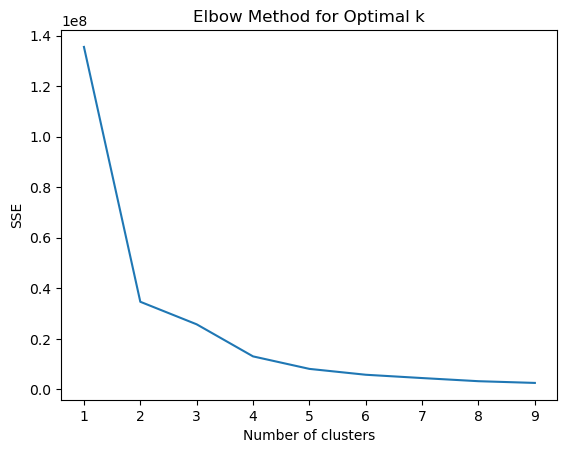

In [8]:
plot_sse_elbow(sub, 'REVENUE_RECALC')

In [9]:
sub = perform_kmeans(sub, 'REVENUE_RECALC', 3, 'REVENUE_RECALC_Cluster')
sub = order_cluster('REVENUE_RECALC_Cluster', 'REVENUE_RECALC', sub, True)
sub.groupby('REVENUE_RECALC_Cluster')['REVENUE_RECALC'].describe()

,count,mean,std,min,25%,50%,75%,max
REVENUE_RECALC_Cluster,,,,,,,,
0,53876.0,22.888360,12.422725,0.00,15.98,19.98,29.97,50.99
1,57765.0,82.715033,15.743800,52.99,72.99,83.93,87.92,364.95
2,27.0,727.413333,178.732205,458.91,583.92,663.92,829.90,1003.00


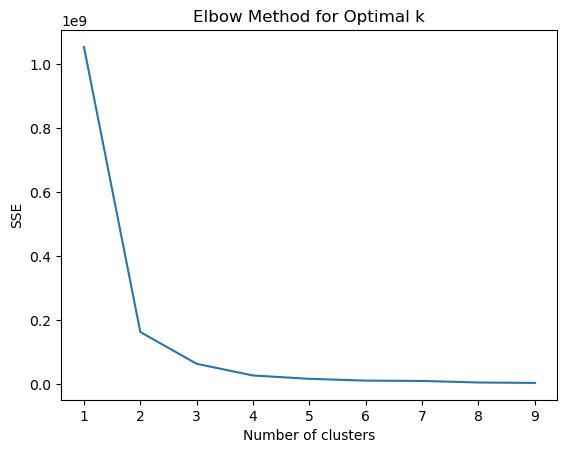

In [10]:
plot_sse_elbow(sub, 'RECENCY')

In [11]:
sub = perform_kmeans(sub, 'RECENCY', 3, 'RECENCY_Cluster')
sub = order_cluster('RECENCY_Cluster', 'RECENCY', sub, True)
sub.groupby('RECENCY_Cluster')['RECENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
RECENCY_Cluster,,,,,,,,
0,54199.0,31.598295,15.223636,1.0,31.0,32.0,32.0,80.0
1,24585.0,129.434655,31.714868,81.0,106.0,123.0,157.0,190.0
2,32884.0,250.965424,28.631006,191.0,214.0,274.0,274.0,304.0


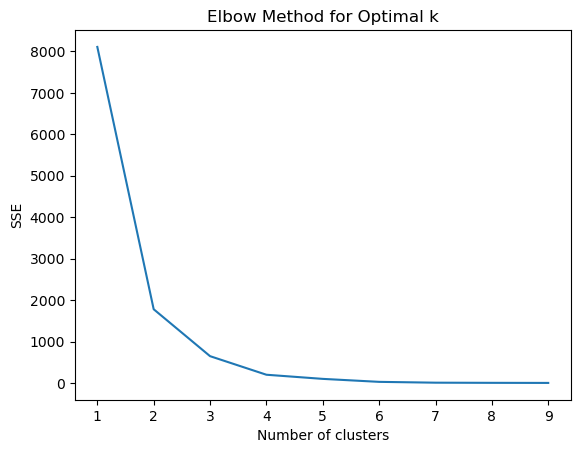

In [12]:
plot_sse_elbow(sub, 'FREQUENCY')

In [13]:
# sub["FREQUENCYCLUSTER"] = sub["FREQUENCYCLUSTER"].replace({2: 0, 1: 2, 0: 1})
sub = perform_kmeans(sub, 'FREQUENCY', 3, 'FREQUENCY_Cluster')
sub = order_cluster('FREQUENCY_Cluster', 'FREQUENCY', sub, False)
sub.groupby('FREQUENCY_Cluster')['FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
FREQUENCY_Cluster,,,,,,,,
0,645.0,3.471318,0.951233,3.0,3.0,3.0,4.0,10.0
1,3853.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,107170.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


## Segment
Combine cluster number info, split into low/mid/high segments

In [15]:
sub['Score'] = sub['RECENCY_Cluster'] + sub['FREQUENCY_Cluster'] + sub['REVENUE_RECALC_Cluster'] 
sub.groupby('Score').agg({'RECENCY':'mean', 'FREQUENCY':'mean','REVENUE_RECALC':'mean'})

,RECENCY,FREQUENCY,REVENUE_RECALC
Score,,,
0,46.405405,3.081081,19.276216
1,47.446914,2.109877,21.108235
2,32.713329,1.019457,19.084055
3,72.941155,1.068708,61.470171
4,165.425529,1.131184,70.715448
5,250.747141,1.000000,88.888133
6,256.578947,1.000000,660.173158


In [16]:
print(sub.groupby('Score')['RECENCY'].count())

Score
0       37
1      810
2    41682
3    24131
4    15261
5    29728
6       19
Name: RECENCY, dtype: int64


In [17]:
sub['Segment'] = 'Mid-Value'
sub.loc[sub['Score'] < 3, 'Segment'] = 'Low-Value' 
sub.loc[sub['Score'] > 4, 'Segment'] = 'High-Value' 

In [18]:
sub_low = sub[sub['Segment']=='Low-Value']
sub_mid = sub[sub['Segment']=='Mid-Value']
sub_high = sub[sub['Segment']=='High-Value']
print(sub_low.shape[0], sub_mid.shape[0], sub_high.shape[0])

42529 39392 29747


## Merge
Merge demographic data with each bucket

In [19]:
sub_low_demo = sub_low.merge(demo, how='inner', on='Capstone_id')
sub_mid_demo = sub_mid.merge(demo, how='inner', on='Capstone_id')
sub_high_demo = sub_high.merge(demo, how='inner', on='Capstone_id')

In [20]:
sub_low_demo.columns

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id',
       'TERM_NUM', 'REVENUE_RECALC', 'REVENUE_RECALC_Cluster',
       'RECENCY_Cluster', 'FREQUENCY_Cluster', 'Score', 'Segment', 'Age',
       'Gender', 'Location', 'Email', 'Income'],
      dtype='object')

In [24]:
print(demo.Capstone_id.isin(sub_low.Capstone_id).sum(),
demo.Capstone_id.isin(sub_mid.Capstone_id).sum(),
demo.Capstone_id.isin(sub_high.Capstone_id).sum())

0 0 0


In [32]:
eda_low = {
    "Total Low-Value Customers": len(sub_low_demo),
    "Unique Brands": sub_low_demo["BRAND"].nunique(),
    "Subscription Terms": sub_low_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_low_demo["RECENCY"].mean(),
    "Average Frequency": sub_low_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_low_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_low_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_low_demo["Age"].describe(),
    "Income Distribution": sub_low_demo["Income"].describe(),
    "Gender Distribution": sub_low_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_low_demo["Location"].value_counts().head(5).to_dict(),
}
eda_low

{'Total Low-Value Customers': 0,
 'Unique Brands': 0,
 'Subscription Terms': {},
 'Average Recency': nan,
 'Average Frequency': nan,
 'Average Monetary Value': nan,
 'Resubscriber Rate': nan,
 'Age Distribution': count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: Age, dtype: float64,
 'Income Distribution': count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: Income, dtype: float64,
 'Gender Distribution': {},
 'Location Breakdown': {}}

In [25]:
eda_mid = {
    "Total Low-Value Customers": len(sub_mid_demo),
    "Unique Brands": sub_mid_demo["BRAND"].nunique(),
    "Subscription Terms": sub_mid_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_mid_demo["RECENCY"].mean(),
    "Average Frequency": sub_mid_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_mid_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_mid_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_mid_demo["Age"].describe(),
    "Income Distribution": sub_mid_demo["Income"].describe(),
    "Gender Distribution": sub_mid_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_mid_demo["Location"].value_counts().head(5).to_dict(),
}
eda_mid

{'Total Low-Value Customers': 0,
 'Unique Brands': 0,
 'Subscription Terms': {},
 'Average Recency': nan,
 'Average Frequency': nan,
 'Average Monetary Value': nan,
 'Resubscriber Rate': nan,
 'Age Distribution': count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: Age, dtype: float64,
 'Income Distribution': count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: Income, dtype: float64,
 'Gender Distribution': {},
 'Location Breakdown': {}}

In [26]:
eda_high = {
    "Total Low-Value Customers": len(sub_high_demo),
    "Unique Brands": sub_high_demo["BRAND"].nunique(),
    "Subscription Terms": sub_high_demo["CURRENT_TERM"].value_counts().to_dict(),
    "Average Recency": sub_high_demo["RECENCY"].mean(),
    "Average Frequency": sub_high_demo["FREQUENCY"].mean(),
    "Average Monetary Value": sub_high_demo["REVENUE_RECALC"].mean(),
    "Resubscriber Rate": sub_high_demo["RESUBSCRIBER"].mean(),
    "Age Distribution": sub_high_demo["Age"].describe(),
    "Income Distribution": sub_high_demo["Income"].describe(),
    "Gender Distribution": sub_high_demo["Gender"].value_counts(normalize=True).to_dict(),
    "Location Breakdown": sub_high_demo["Location"].value_counts().head(5).to_dict(),
}
eda_high

{'Total Low-Value Customers': 0,
 'Unique Brands': 0,
 'Subscription Terms': {},
 'Average Recency': nan,
 'Average Frequency': nan,
 'Average Monetary Value': nan,
 'Resubscriber Rate': nan,
 'Age Distribution': count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: Age, dtype: float64,
 'Income Distribution': count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: Income, dtype: float64,
 'Gender Distribution': {},
 'Location Breakdown': {}}

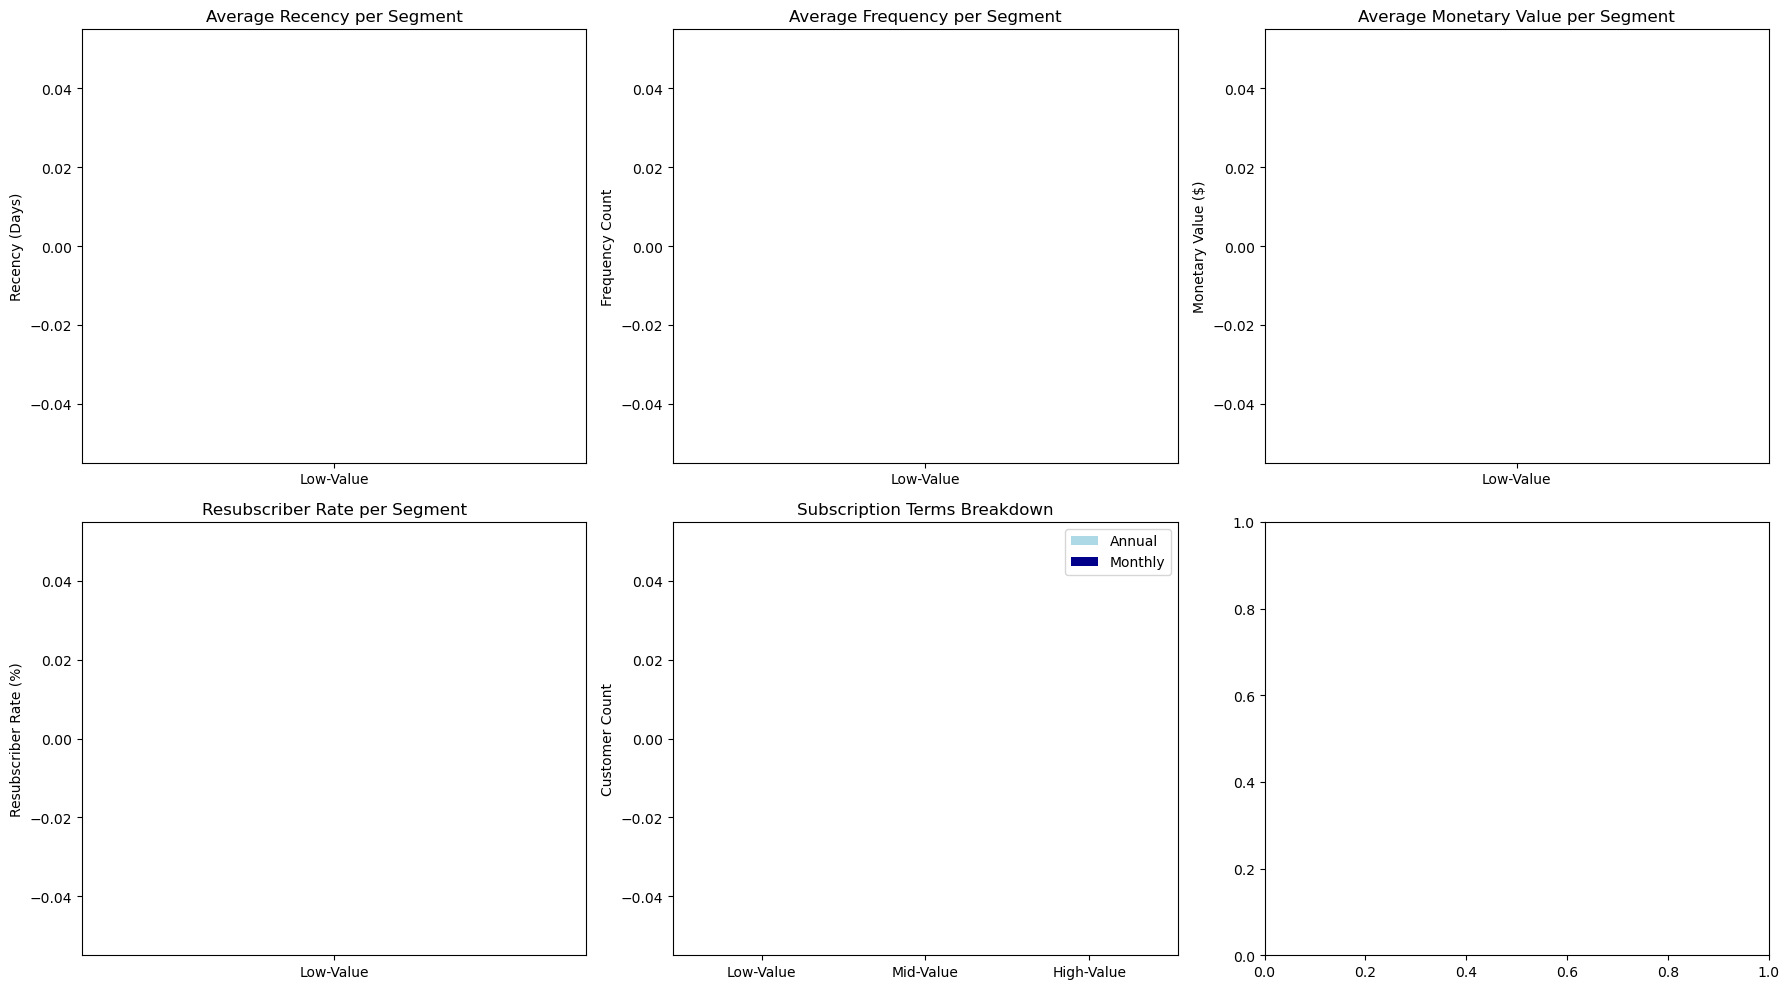

In [27]:
# Extract values for visualization
segments = ["Low-Value", "Mid-Value", "High-Value"]
avg_revenue = [
    eda_low["Average Recency"],
    eda_mid["Average Recency"],
    eda_high["Average Recency"]
]
avg_frequency = [
    eda_low["Average Frequency"],
    eda_mid["Average Frequency"],
    eda_high["Average Frequency"]
]
avg_monetary = [
    eda_low["Average Monetary Value"],
    eda_mid["Average Monetary Value"],
    eda_high["Average Monetary Value"]
]
resubscriber_rate = [
    eda_low["Resubscriber Rate"],
    eda_mid["Resubscriber Rate"],
    eda_high["Resubscriber Rate"]
]
subscription_terms = {
    "Annual": [
        eda_low["Subscription Terms"].get("annual", 0),
        eda_mid["Subscription Terms"].get("annual", 0),
        eda_high["Subscription Terms"].get("annual", 0)
    ],
    "Monthly": [
        eda_low["Subscription Terms"].get("monthly", 0),
        eda_mid["Subscription Terms"].get("monthly", 0),
        eda_high["Subscription Terms"].get("monthly", 0)
    ]
}

# Extract key metrics for visualization
segments = ["Low-Value", "Mid-Value", "High-Value"]

# Data to be visualized
avg_recency = [
    eda_low["Average Recency"],
    eda_mid["Average Recency"],
    eda_high["Average Recency"]
]

avg_frequency = [
    eda_low["Average Frequency"],
    eda_mid["Average Frequency"],
    eda_high["Average Frequency"]
]

avg_monetary = [
    eda_low["Average Monetary Value"],
    eda_mid["Average Monetary Value"],
    eda_high["Average Monetary Value"]
]

resubscriber_rate = [
    eda_low["Resubscriber Rate"],
    eda_mid["Resubscriber Rate"],
    eda_high["Resubscriber Rate"]
]

# Subscription Terms Breakdown
subscription_terms = {
    "Annual": [
        eda_low["Subscription Terms"].get("annual", 0),
        eda_mid["Subscription Terms"].get("annual", 0),
        eda_high["Subscription Terms"].get("annual", 0)
    ],
    "Monthly": [
        eda_low["Subscription Terms"].get("monthly", 0),
        eda_mid["Subscription Terms"].get("monthly", 0),
        eda_high["Subscription Terms"].get("monthly", 0)
    ]
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Average Recency
axes[0, 0].bar(segments, avg_recency, color=['blue', 'green', 'red'])
axes[0, 0].set_title("Average Recency per Segment")
axes[0, 0].set_ylabel("Recency (Days)")

# Plot Average Frequency
axes[0, 1].bar(segments, avg_frequency, color=['blue', 'green', 'red'])
axes[0, 1].set_title("Average Frequency per Segment")
axes[0, 1].set_ylabel("Frequency Count")

# Plot Average Monetary Value
axes[0, 2].bar(segments, avg_monetary, color=['blue', 'green', 'red'])
axes[0, 2].set_title("Average Monetary Value per Segment")
axes[0, 2].set_ylabel("Monetary Value ($)")

# Plot Resubscriber Rate
axes[1, 0].bar(segments, resubscriber_rate, color=['blue', 'green', 'red'])
axes[1, 0].set_title("Resubscriber Rate per Segment")
axes[1, 0].set_ylabel("Resubscriber Rate (%)")

# Plot Subscription Term Distribution
x = np.arange(len(segments))
width = 0.4

axes[1, 1].bar(x - width/2, subscription_terms["Annual"], width, label='Annual', color='lightblue')
axes[1, 1].bar(x + width/2, subscription_terms["Monthly"], width, label='Monthly', color='darkblue')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(segments)
axes[1, 1].set_title("Subscription Terms Breakdown")
axes[1, 1].set_ylabel("Customer Count")
axes[1, 1].legend()

# Display plots
plt.tight_layout()
plt.show()

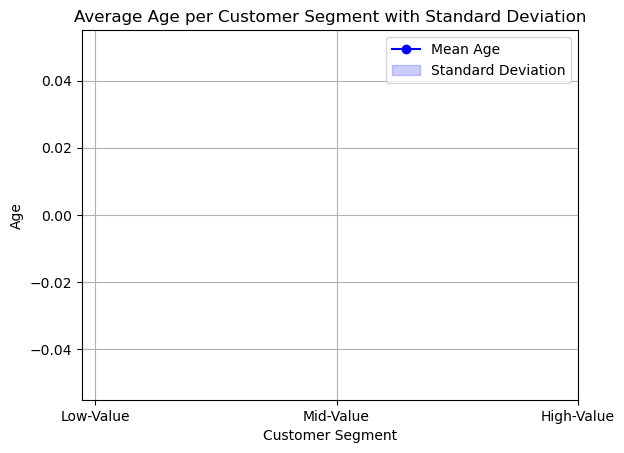

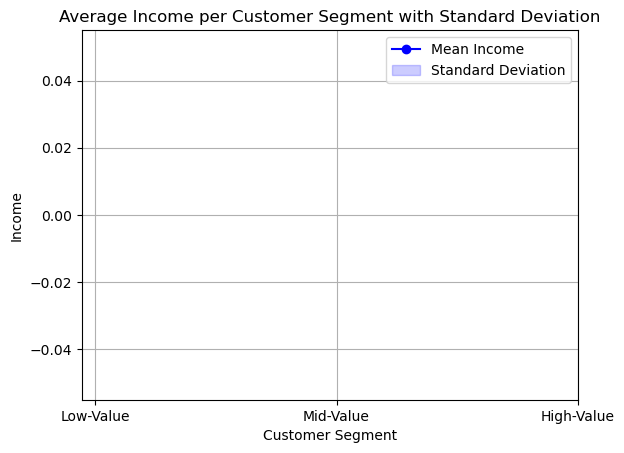

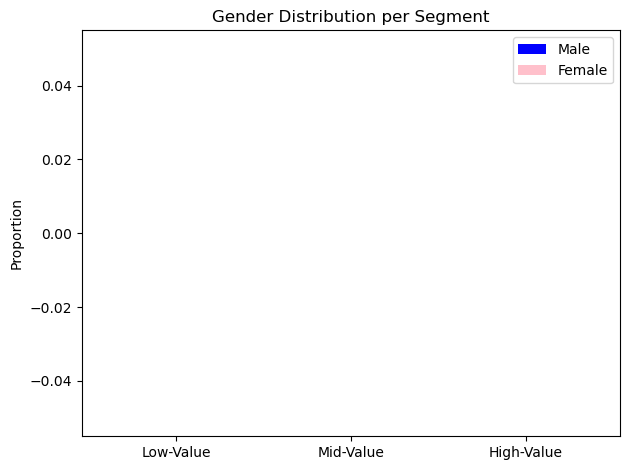

In [36]:
# Extracting relevant data from the summary dictionaries
segments = ["Low-Value", "Mid-Value", "High-Value"]

# Age statistics
age_mean = [
    eda_low["Age Distribution"]["mean"],
    eda_mid["Age Distribution"]["mean"],
    eda_high["Age Distribution"]["mean"]
]

age_std = [
    eda_low["Age Distribution"]["std"],
    eda_mid["Age Distribution"]["std"],
    eda_high["Age Distribution"]["std"]
]

# Convert segments into numerical indices for plotting
x = np.arange(len(segments))

# Plot the line graph for Age Mean
plt.plot(x, age_mean, marker='o', linestyle='-', color='blue', label="Mean Age")

# Add shaded region for standard deviation (Error bars)
plt.fill_between(x, np.array(age_mean) - np.array(age_std), np.array(age_mean) + np.array(age_std), 
                 color='blue', alpha=0.2, label="Standard Deviation")

# Customize the plot
plt.xticks(x, segments)  # Set x-axis labels
plt.xlabel("Customer Segment")
plt.ylabel("Age")
plt.title("Average Age per Customer Segment with Standard Deviation")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Income statistics
income_mean = [
    eda_low["Income Distribution"]["mean"],
    eda_mid["Income Distribution"]["mean"],
    eda_high["Income Distribution"]["mean"]
]

income_std = [
    eda_low["Income Distribution"]["std"],
    eda_mid["Income Distribution"]["std"],
    eda_high["Income Distribution"]["std"]
]

# Convert segments into numerical indices for plotting
x = np.arange(len(segments))

# Plot the line graph for Age Mean
plt.plot(x, income_mean, marker='o', linestyle='-', color='blue', label="Mean Income")

# Add shaded region for standard deviation (Error bars)
plt.fill_between(x, np.array(income_mean) - np.array(income_std), np.array(income_mean) + np.array(income_std), 
                 color='blue', alpha=0.2, label="Standard Deviation")

# Customize the plot
plt.xticks(x, segments)  # Set x-axis labels
plt.xlabel("Customer Segment")
plt.ylabel("Income")
plt.title("Average Income per Customer Segment with Standard Deviation")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Gender distribution
gender_male = [
    eda_low["Gender Distribution"].get("Male", 0),
    eda_mid["Gender Distribution"].get("Male", 0),
    eda_high["Gender Distribution"].get("Male", 0)
]

gender_female = [
    eda_low["Gender Distribution"].get("Female", 0),
    eda_mid["Gender Distribution"].get("Female", 0),
    eda_high["Gender Distribution"].get("Female", 0)
]

plt.bar(x - width / 2, gender_male, width, label='Male', color='blue')
plt.bar(x + width / 2, gender_female, width, label='Female', color='pink')
plt.xticks(x, labels=segments)
plt.title("Gender Distribution per Segment")
plt.ylabel("Proportion")
plt.legend()

# Display plots
plt.tight_layout()
plt.show()


In [55]:
eda_low['Gender Distribution']

{'Male': 0.4970700310608729,
 'Female': 0.4495821191840917,
 'Other': 0.053347849755035384}

In [57]:
eda_mid['Gender Distribution']

{'Male': 0.5004432830945826,
 'Female': 0.4494579503211858,
 'Other': 0.05009876658423156}

In [56]:
eda_high['Gender Distribution']

{'Male': 0.49764647590734545,
 'Female': 0.4537346711259755,
 'Other': 0.04861885296667905}

# Sub Stats

In [25]:
sub.columns

Index(['RECENCY', 'SUB_START', 'SUB_END', 'FREQUENCY', 'CURRENT_TERM',
       'MONETARY', 'REVENUE', 'RESUBSCRIBER', 'BRAND', 'Capstone_id',
       'TERM_NUM', 'REVENUE_RECALC', 'REVENUE_RECALC_Cluster',
       'RECENCY_Cluster', 'FREQUENCY_Cluster', 'Score', 'Segment'],
      dtype='object')

## Summary: RFM, Resub

In [42]:
# Grouping data by 'Segment' and calculating key statistics
segment_summary = sub.groupby("Segment").agg({
    "RECENCY": ["mean", "median"],
    "FREQUENCY": ["mean", "median"],
    "REVENUE_RECALC": ["mean", "sum"],
    "RESUBSCRIBER": ["mean"]
}).round(2)
segment_summary

RECENCY        FREQUENCY        REVENUE_RECALC              \
              mean median      mean median           mean         sum   
Segment                                                                 
High-Value  250.75  274.0      1.00    1.0          89.25  2655009.72   
Low-Value    33.01   32.0      1.04    1.0          19.12   813272.46   
Mid-Value   108.77  106.0      1.09    1.0          65.05  2562525.15   

           RESUBSCRIBER  
                   mean  
Segment                  
High-Value         0.00  
Low-Value          0.04  
Mid-Value          0.08

## Distribution across segment
### Revenue boxplot

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_42295/4273420844.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




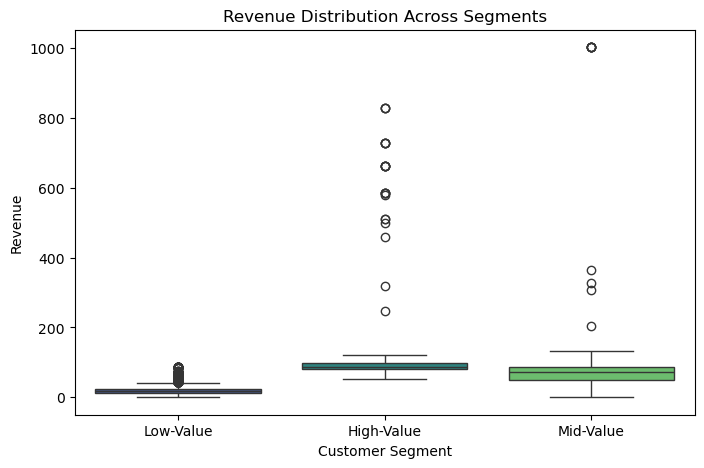

In [43]:
# Boxplot for Revenue by Segment
plt.figure(figsize=(8,5))
sns.boxplot(x="Segment", y="REVENUE_RECALC", data=sub, palette="viridis")
plt.title("Revenue Distribution Across Segments")
plt.xlabel("Customer Segment")
plt.ylabel("Revenue")
plt.show()

### Sub term distribution

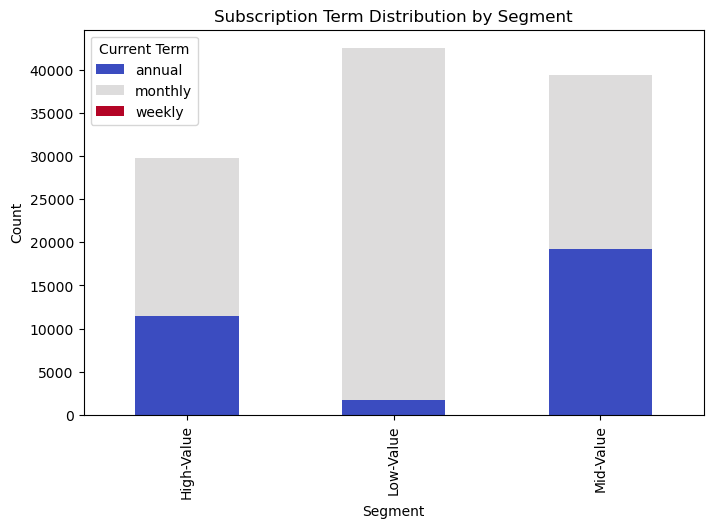

In [55]:
# Count of subscription terms by segment
term_counts = sub.groupby(["Segment", "CURRENT_TERM"]).size().unstack()

# Plot distribution of subscription terms across segments
term_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="coolwarm")
plt.title("Subscription Term Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Current Term")
plt.show()

In [57]:
# Calculate the percentage of annual/monthly subscriptions within each segment
term_counts_percentage = term_counts.div(term_counts.sum(axis=1), axis=0) * 100
term_counts_percentage

CURRENT_TERM,annual,monthly,weekly
Segment,,,
High-Value,38.511447,61.481830,0.006723
Low-Value,4.138353,95.861647,NaN
Mid-Value,48.768786,51.231214,NaN


### Recency & Freq

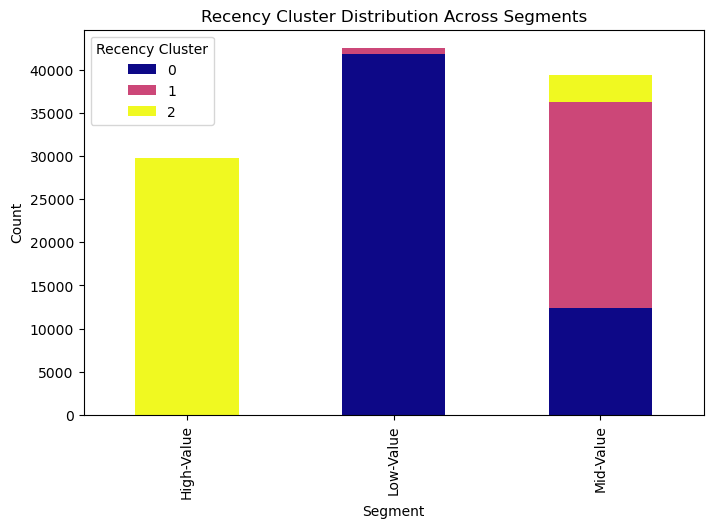

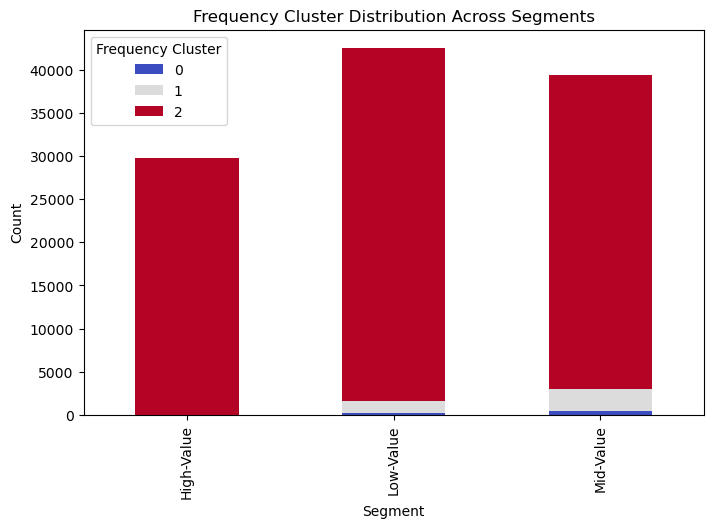

In [51]:
# Count distribution of Recency and Frequency Clusters
recency_cluster_counts = sub.groupby("Segment")["RECENCY_Cluster"].value_counts().unstack()
frequency_cluster_counts = sub.groupby("Segment")["FREQUENCY_Cluster"].value_counts().unstack()

# Plot Recency Cluster Distribution
recency_cluster_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="plasma")
plt.title("Recency Cluster Distribution Across Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Recency Cluster")
plt.show()

# Plot Frequency Cluster Distribution
frequency_cluster_counts.plot(kind="bar", stacked=True, figsize=(8,5), colormap="coolwarm")
plt.title("Frequency Cluster Distribution Across Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.legend(title="Frequency Cluster")
plt.show()


# Demo Stats

In [26]:
demo.columns

Index(['Capstone_id', 'Age', 'Gender', 'Location', 'Email', 'Income'], dtype='object')

## Age

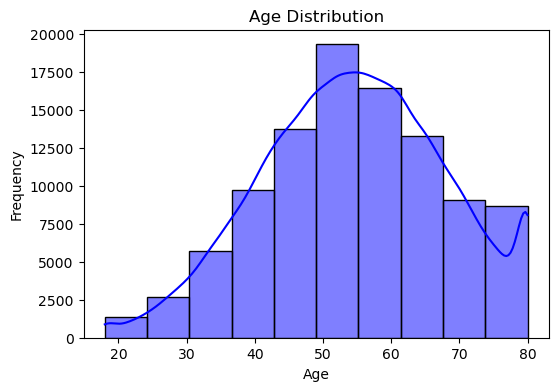

In [47]:
# Age Distribution Plot
plt.figure(figsize=(6,4))
sns.histplot(demo["Age"], bins=10, kde=True, color="blue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

## Gender

In [27]:
# Gender Distribution
gender_counts = demo["Gender"].value_counts()
gender_counts

Gender
Male      49912
Female    45019
Other      5069
Name: count, dtype: int64

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_42295/1507335075.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




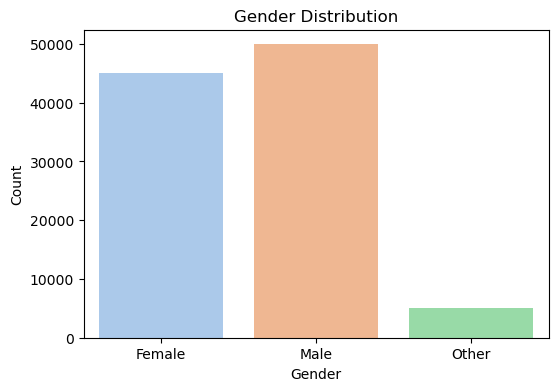

In [28]:
# Gender Count Plot
plt.figure(figsize=(6,4))
sns.countplot(x=demo["Gender"], palette="pastel")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

## Income

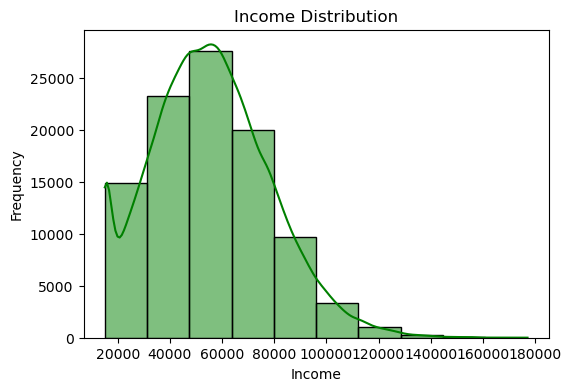

In [29]:
# Income Distribution Plot
plt.figure(figsize=(6,4))
sns.histplot(demo["Income"], bins=10, kde=True, color="green")
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_42295/1726537035.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




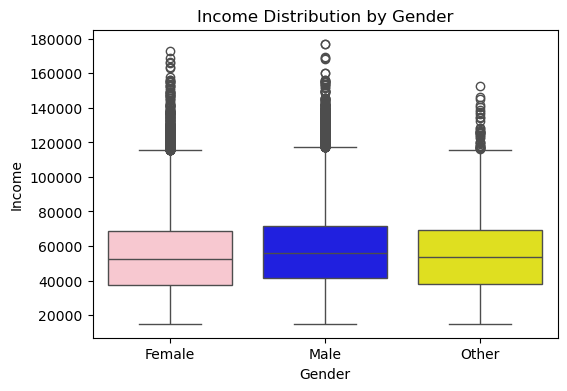

In [30]:
# Compare income distribution between male and female
plt.figure(figsize=(6,4))
sns.boxplot(x="Gender", y="Income", data=demo, palette={"Male": "blue", "Female": "pink", "Other":"yellow"})
plt.title("Income Distribution by Gender")
plt.show()

## Location

In [31]:
# Most common customer locations
top_locations = demo["Location"].value_counts().head(5)
top_locations

Location
New Michael      105
Port Michael      87
South Michael     85
North Michael     85
West Michael      84
Name: count, dtype: int64

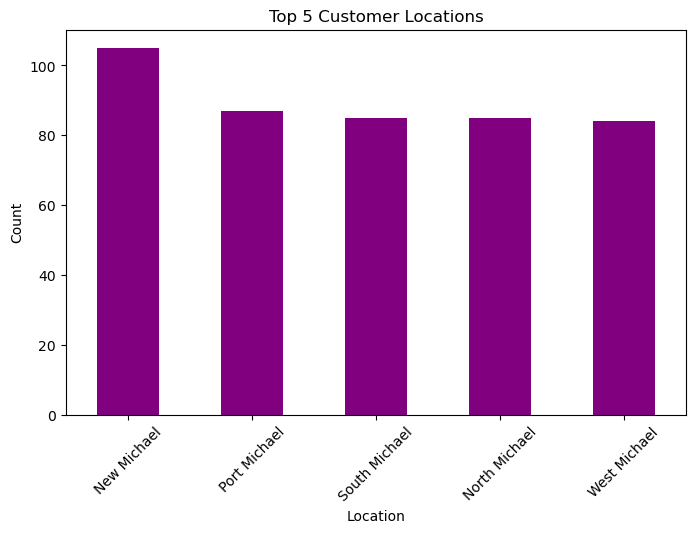

In [32]:
plt.figure(figsize=(8,5))
top_locations.plot(kind="bar", color="purple")
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Top 5 Customer Locations")
plt.xticks(rotation=45)
plt.show()

## Clustering

Based on full demo data (w/o mapping to sub data's segmentation), the most determinant factor on clustering is `income`. No big difference across various genders and/or ages.

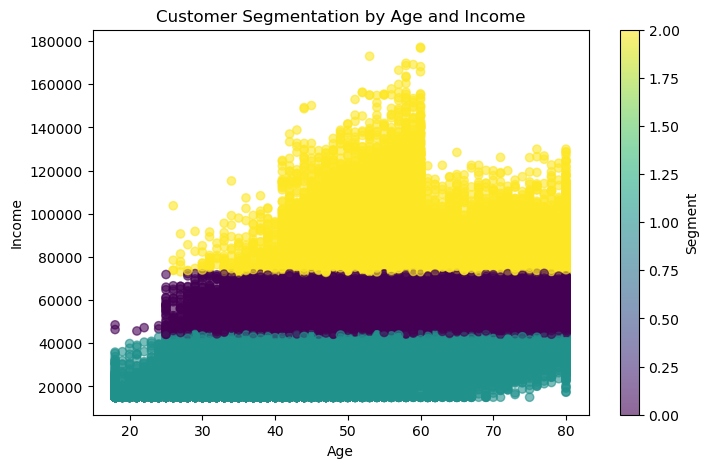

In [36]:
from sklearn.cluster import KMeans

# Select numerical features for clustering
X = demo[["Age", "Income"]]

# Apply K-Means with 3 clusters (Low, Mid, High)
kmeans = KMeans(n_clusters=3, random_state=42)
demo["Segment"] = kmeans.fit_predict(X)

# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Age"], demo["Income"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Customer Segmentation by Age and Income")
plt.colorbar(label="Segment")
plt.show()


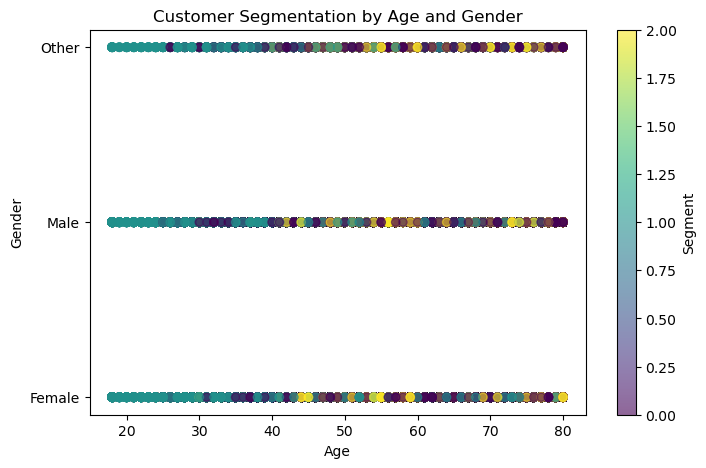

In [38]:
# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Age"], demo["Gender"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Gender")
plt.title("Customer Segmentation by Age and Gender")
plt.colorbar(label="Segment")
plt.show()

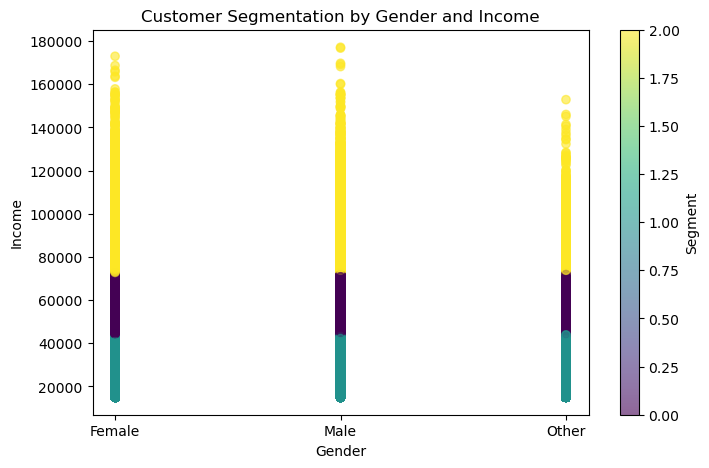

In [39]:
# Visualizing clusters
plt.figure(figsize=(8,5))
plt.scatter(demo["Gender"], demo["Income"], c=demo["Segment"], cmap="viridis", alpha=0.6)
plt.xlabel("Gender")
plt.ylabel("Income")
plt.title("Customer Segmentation by Gender and Income")
plt.colorbar(label="Segment")
plt.show()